In [38]:
using POMDPs
using POMDPToolbox
using POMDPModels
using Interact
value = Interact.value

value (generic function with 2 methods)

# More on GridWorld

In [3]:
?GridWorld

search: GridWorld GridWorldState GridWorldAction GridWorldStateSpace



No documentation found.

**Summary:**

```
type POMDPModels.GridWorld <: POMDPs.MDP{POMDPModels.GridWorldState,Symbol}
```

**Fields:**

```
size_x          :: Int64
size_y          :: Int64
reward_states   :: Array{POMDPModels.GridWorldState,1}
reward_values   :: Array{Float64,1}
bounds_penalty  :: Float64
tprob           :: Float64
terminals       :: Set{POMDPModels.GridWorldState}
discount_factor :: Float64
```


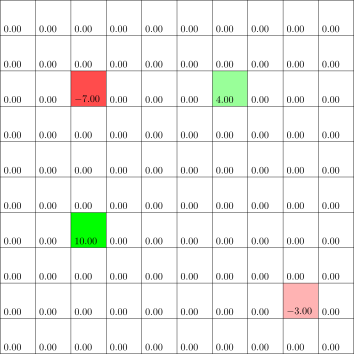

In [8]:
# You can change the gridworld like this
rstates = [(3,4), (7,8), (9,2), (3,8)]
rvals = [10.0, 4.0, -3.0, -7.0]
mdp = GridWorld(
    rs = [GridWorldState(xy...) for xy in rstates],
    rv = rvals,
    tp = 0.7, # probability of transition in the action direction
    discount_factor = 0.95
)
plot(mdp, s->reward(mdp, s, :up))

# Policy Evaluation

This function creates the transition matrix, $T^\pi$

In [9]:
"""
Return the state transition matrix for a policy and an MDP.

T[i,j] = probability of transitioning from i to j
"""
function trans_mat(mdp::MDP, policy::Policy)
    n = n_states(mdp)
    T = spzeros(n, n)
    for s in iterator(states(mdp))
        i = state_index(mdp, s)
        tdist = transition(mdp, s, action(policy, s))
        for sp in iterator(tdist)
            p = pdf(tdist, sp)
            if p > 0.0
                j = state_index(mdp, sp)
                T[i,j] = p
            end
        end
    end
    return T
end

trans_mat

The block below creates a random policy, $\pi_k$, represented as a vector, evaluates the policy, and plots it.

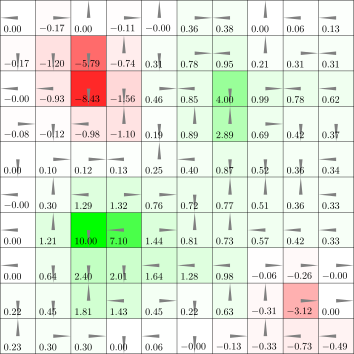

In [45]:
n = n_states(mdp)
pi_k = rand(actions(mdp), n_states(mdp));
Tpi = trans_mat(mdp, VectorPolicy(mdp, pi_k))
Rpi = [reward(mdp, s, action(VectorPolicy(mdp, pi_k), s)) for s in iterator(states(mdp))]
Upi = inv(eye(n) - discount(mdp)*Tpi)*Rpi
plot(mdp, Upi, VectorPolicy(mdp, pi_k))

# Policy Iteration

The cell below runs policy iteration, then plots the policy along with the associated value function.

Interact.Options{:SelectionSlider,Int64}(5: "input-2" = 3 Int64 ,"i",3,"3",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5),Dict(4=>"4",2=>"2",3=>"3",5=>"5",1=>"1")),Any[],Any[],true,"horizontal")

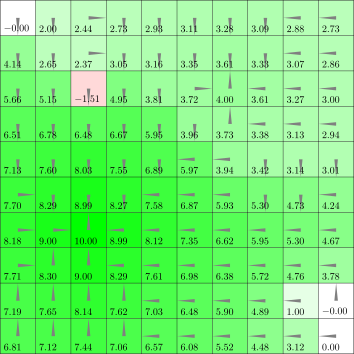

In [46]:
pi_k = rand(actions(mdp), n_states(mdp));


while true    
    # new policy vector
    pi_kp1 = Vector{action_type(mdp)}(n_states(mdp))

    # transition matrix
    Tpi = trans_mat(mdp, VectorPolicy(mdp, pi_k))

    # evaluate the policy
    Upik = inv(eye(n) - discount(mdp) * Tpi) * Rpi

    # calculate pi_kp1
    for s in iterator(states(mdp))
        best = -Inf
        best_a = nothing

        for a in iterator(actions(mdp))
            # Calculate expectation of U(s')
            exp_Usp = 0.0
            tdist = transition(mdp, s, a)
            for sp in iterator(tdist)
                p = pdf(tdist, sp)
                if p > 0.0
                    exp_Usp += p*Upik[state_index(mdp, sp)]
                end
            end

            # find the value of taking the action
            Q = reward(mdp, s, a) + discount(mdp)*exp_Usp
            if Q > best
                best = Q
                best_a = a
            end
        end
        pi_kp1[state_index(mdp, s)] = best_a
    end

    if pi_k == pi_kp1
        break
    end
    
    pi_k = pi_kp1
    
    push!(plots, plot(mdp, Upik, VectorPolicy(mdp, pi_kp1)))
end

@manipulate for i in 1:length(plots)
    plots[i]
end

The policy can also be plotted without the value function:

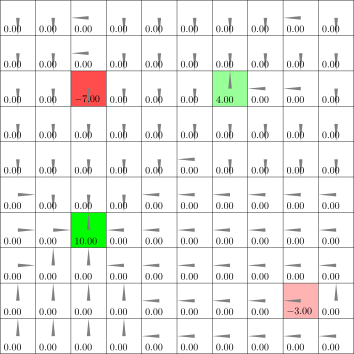

In [34]:
plot(mdp, s->reward(mdp, s, :up), VectorPolicy(mdp, pi_kp1))